In [2]:
!git clone https://github.com/olegolas912/ConDiff.git
# !pip install -r requirements.txt
!pip install --upgrade "jax[cuda12]==0.6.0" jax-cuda12-plugin==0.6.0
!pip install equinox
!pip install parafields
%cd /kaggle/working/ConDiff

fatal: destination path 'ConDiff' already exists and is not an empty directory.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 90.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 MB 13.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 MB 11.6 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 87.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 45.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: jax-cuda12-pjrt
    Found existing installation: jax-cuda12-pjrt 0.5.1
    Uninstalling jax-cuda12-pjrt-0.5.1:
      Successfully uninstalled jax-cuda12-pjrt-0.5.1
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.3.0.75
    Uni

In [3]:
!rm -r /kaggle/working/ConDiff/ConDiff/poisson_grid128

rm: cannot remove '/kaggle/working/ConDiff/ConDiff/poisson_grid128': No such file or directory


In [4]:
import jax.numpy as jnp
import os
import jax

# jax.config.update("jax_enable_x64", True)
# jax.config.update('jax_platforms', 'cpu')
# os.environ["CUDA_VISIBLE_DEVICES"] = ''
# os.environ["JAX_PLATFORMS"] = 'cpu'

from condiff import multiple_poisson, multiple_diffusion
path = "/kaggle/working/ConDiff"
try:
    os.mkdir(os.path.join(path, 'ConDiff'))
except:
    pass
save_dir = os.path.join(path, 'ConDiff')
# Parameters for Poisson and diffusion euqtions
N_train = 1000
N_test = 200
grid_ls = [64, 128]

# Parameters only for diffusion equation
cov_model_ls = ['cubic', 'exponential', 'gaussian']
boundaries_ls = [                                          # Contrast boundaries to control complexity
    [[5, 15], [50, 250], [600, 1000], [80000, 100000]],
    [[5, 15], [50, 250], [600, 1000], [80000, 100000]]
]
var_ls = [0.1, 0.4, 1.0, 2.0]
multiple_poisson(save_dir, N_train, N_test, grid_ls, seed_rng=42)

In [5]:
!ls
%cd /kaggle/working/ConDiff

poisson_grid128_test.h5  poisson_grid128_train.h5
/kaggle/working/ConDiff


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.op = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_ch, out_ch))

    def forward(self, x):
        return self.op(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diff_y = x2.size(2) - x1.size(2)
        diff_x = x2.size(3) - x1.size(3)
        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet2d(nn.Module):
    def __init__(self, in_channels=1, out_channels=1,
                 init_features=32, depth=4, bilinear=True):
        super().__init__()
        feats = [init_features * (2 ** i) for i in range(depth + 1)]

        self.inc  = DoubleConv(in_channels, feats[0])
        self.down = nn.ModuleList([Down(feats[i], feats[i + 1]) for i in range(depth)])

        self.up = nn.ModuleList([
            Up(feats[i + 1] + feats[i], feats[i], bilinear)
            for i in range(depth - 1, -1, -1)
        ])

        self.outc = OutConv(feats[0], out_channels)

    def forward(self, x):
        skips = []
        x = self.inc(x)
        skips.append(x)
        for d in self.down:
            x = d(x)
            skips.append(x)

        for i, u in enumerate(self.up):
            x = u(x, skips[-(i + 2)])
        return self.outc(x)

def get_UNet_pt(in_channels=1, out_channels=1,
                init_features=32, depth=4, bilinear=True,
                device="cuda" if torch.cuda.is_available() else "cpu"):
    model = UNet2d(in_channels, out_channels, init_features, depth, bilinear)
    return model.to(device)


In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
model = get_UNet_pt(in_channels=1, out_channels=1)
CHECKPOINT_PATH = "unet_poisson64.pth"

In [ ]:
def relative_error(pred, targ):
    return ((pred - targ).view(pred.size(0), -1).norm(dim=1) /
            targ.view(targ.size(0), -1).norm(dim=1))

def save_checkpoint(model, optimizer, epoch, history, path=CHECKPOINT_PATH):
    torch.save({
        "epoch":   epoch,
        "model":   model.state_dict(),
        "optim":   optimizer.state_dict(),
        "history": history,
    }, path)

def load_checkpoint(model, optimizer=None, path=CHECKPOINT_PATH, map_location="cpu"):
    ckpt = torch.load(path, map_location=map_location)
    model.load_state_dict(ckpt["model"])
    if optimizer is not None:
        optimizer.load_state_dict(ckpt["optim"])
    return ckpt["epoch"], ckpt["history"]

def huber_relative_error(pred, targ, delta=0.01):
    diff = pred - targ
    abs_diff = diff.abs()
    quad = torch.clamp(abs_diff, max=delta)
    lin  = abs_diff - quad
    huber = 0.5 * quad.pow(2) / delta + lin           # SmoothL1 вручную
    per_sample = huber.view(huber.size(0), -1).sum(dim=1)
    denom = targ.view(targ.size(0), -1).norm(dim=1) + 1e-8
    return per_sample / denom


In [ ]:
from tqdm.auto import tqdm
import torch, math

def train_model_pt(
    model_data,
    features,
    targets,
    spec,
    device="cuda" if torch.cuda.is_available() else "cpu",
    use_huber=False,
    mixed_precision=True,
    grad_clip=1.0,
):
    model = model_data["model"].to(device)
    feats_tr, feats_ts = (f.to(device) for f in features)
    targs_tr, targs_ts = (t.to(device) for t in targets)

    opt = torch.optim.AdamW(
        model.parameters(),
        lr=spec["learning_rate"],
        weight_decay=spec["weight_decay"],
    )

    steps_per_epoch = math.ceil(feats_tr.size(0) / spec["batch_size"])
    total_steps     = spec["N_epochs"] * steps_per_epoch
    warmup_steps    = int(0.05 * total_steps)

    def lr_lambda(step):
        if step < warmup_steps:
            return step / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        return 0.5 * (1 + math.cos(math.pi * progress))      # cosine ↓ to 0

    scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

    loss_fn = huber_relative_error if use_huber else relative_error
    scaler  = torch.cuda.amp.GradScaler(enabled=mixed_precision)

    best_test = float("inf")
    hist_train, hist_test = [], []

    global_step = 0
    epoch_bar = tqdm(range(1, spec["N_epochs"] + 1), desc="Epochs", position=0)

    for epoch in epoch_bar:
        model.train()
        perm = torch.randperm(feats_tr.size(0), device=device)

        batch_bar = tqdm(range(0, len(perm), spec["batch_size"]),
                         desc=f"e{epoch}", leave=False, position=1)

        for i in batch_bar:
            idx = perm[i : i + spec["batch_size"]]
            x, y = feats_tr[idx], targs_tr[idx]

            with torch.cuda.amp.autocast(enabled=mixed_precision):
                pred = model(x)
                loss = loss_fn(pred, y).mean()

            scaler.scale(loss).backward()
            if grad_clip is not None:
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            scaler.step(opt)
            scaler.update()
            scheduler.step()
            opt.zero_grad(set_to_none=True)

            global_step += 1
            batch_bar.set_postfix(
                train_loss=f"{loss.item():.3e}",
                lr=scheduler.get_last_lr()[0]
            )

        model.eval()
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=mixed_precision):
            val_pred  = model(feats_ts)
            val_loss  = loss_fn(val_pred, targs_ts).mean()

        hist_train.append(loss.item())
        hist_test.append(val_loss.item())
        epoch_bar.set_postfix(
            train=f"{loss.item():.3e}",
            test=f"{val_loss.item():.3e}",
            lr=scheduler.get_last_lr()[0]
        )

        if val_loss < best_test:
            best_test = val_loss
            save_checkpoint(
                model, opt, epoch,
                {"train": hist_train, "test": hist_test},
                path=CHECKPOINT_PATH
            )

    return model, hist_train, hist_test


In [ ]:
def get_UNet(grid: int, device: torch.device):

    model = get_UNet_pt(
        in_channels  = 1,
        out_channels = 1,
        init_features = 32,     
        depth         = 4,      
        device        = device,
    )

    spec = dict(
        N_epochs      = 200,  
        batch_size    = 16,
        learning_rate = 1e-3,
        weight_decay  = 1e-4,
    )
    return {"model": model}, spec




In [ ]:
def get_results(grid, type_of_pde="poisson", direction_to_save="ConDiff"):
    import load_ConDiff
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    (feat_tr, targ_tr), (feat_ts, targ_ts) = load_ConDiff.get_datasets(
        direction_to_save, type_of_pde, grid
    )
    feat_tr = torch.tensor(feat_tr, dtype=torch.float32, device=device)
    targ_tr = torch.tensor(targ_tr, dtype=torch.float32, device=device)
    feat_ts = torch.tensor(feat_ts, dtype=torch.float32, device=device)
    targ_ts = torch.tensor(targ_ts, dtype=torch.float32, device=device)

    model_data, spec = get_UNet(grid, device)   # ← было get_SNO
    model, h_train, h_test = train_model_pt(
        model_data,
        [feat_tr, feat_ts],
        [targ_tr, targ_ts],
        spec,
        device,
        use_huber=True,
    )

    model.eval()
    with torch.no_grad():
        pred = model(feat_ts)
        err  = relative_error(pred, targ_ts)

    data = {
        "history_train": h_train,
        "history_test":  h_test,
        "test_error_mean": err.mean().item(),
        "test_error_std":  err.std().item(),
    }
    return data, model, model_data, feat_ts, targ_ts


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
try:
    from IPython import display
    IN_NOTEBOOK = True
except ImportError:
    IN_NOTEBOOK = False

def plot_results(model, history, features_test, targets_test):
    model.eval()
    with torch.no_grad():
        pred = model(features_test).cpu().numpy()[:, 0]   # (N,H,W)

    targ = targets_test.cpu().numpy()[:, 0]

    if IN_NOTEBOOK:
        display.clear_output(wait=True)

    plt.rcParams["font.family"] = "serif"

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    # кривая потерь
    ax[0].set_title("Loss")
    ax[0].set_yscale("log")
    ax[0].plot(history["history_train"], "-",  color="red",   label="train")
    ax[0].plot(history["history_test"],  "-.", color="green", label="test")
    ax[0].legend()
    ax[0].grid(ls="--", alpha=0.5)
    ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Relative error")
    ax[0].spines[["top", "right"]].set_visible(False)

    # предсказание и таргет
    im1 = ax[1].imshow(pred[0], cmap="viridis")
    ax[1].set_title("Prediction")
    plt.colorbar(im1, ax=ax[1], fraction=0.046)

    im2 = ax[2].imshow(targ[0], cmap="viridis")
    ax[2].set_title("Target")
    plt.colorbar(im2, ax=ax[2], fraction=0.046)

    plt.tight_layout()
    plt.show()


In [14]:
%cd /kaggle/working/ConDiff

/kaggle/working/ConDiff


In [ ]:
import os, shutil, glob, pathlib

ROOT = "/kaggle/working/ConDiff"

extra_dirs = ["poisson_grid64", "poisson_grid128"]
for name in extra_dirs:
    src = os.path.join(ROOT,"ConDiff", name)
    dst = os.path.join(ROOT, "ConDiff", "df","ConDiff", name)
    if os.path.exists(src) and not os.path.exists(dst):
        print(f"→ move {src}  →  {dst}")
        shutil.move(src, dst)
    else:
        print(f"✓ {name} уже на месте или не найден")

print("\n📂  Структура каталогов поправлена.")


✓ poisson_grid64 уже на месте или не найден
✓ poisson_grid128 уже на месте или не найден

📂  Структура каталогов поправлена.


In [ ]:
def huber_relative_error(pred, targ, delta=0.01):
    diff = pred - targ
    abs_diff = diff.abs()
    quad = torch.clamp(abs_diff, max=delta)
    lin  = abs_diff - quad
    huber = 0.5 * quad.pow(2) / delta + lin
    per_sample = huber.view(huber.size(0), -1).sum(dim=1)
    denom = targ.view(targ.size(0), -1).norm(dim=1) + 1e-8
    return per_sample / denom


In [17]:
import torch.nn.functional as F


In [ ]:
import os, torch
from load_ConDiff import load_ConDiff

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grid   = 64
CHECKPOINT_PATH = "unet_poisson64.pth"         

model_data, spec = get_UNet(grid, device)      
model = model_data["model"]

save_dir = "/kaggle/working/ConDiff/ConDiff"
(rhs_tr, x_tr), (rhs_ts, x_ts) = load_ConDiff(save_dir, "poisson", grid)

rhs_tr = rhs_tr.reshape(-1, 1, grid, grid)
x_tr   = x_tr.reshape(-1, 1, grid, grid)
rhs_ts = rhs_ts.reshape(-1, 1, grid, grid)
x_ts   = x_ts.reshape(-1, 1, grid, grid)

feat_tr = torch.tensor(rhs_tr, dtype=torch.float32, device=device)
targ_tr = torch.tensor(x_tr,   dtype=torch.float32, device=device)
feat_ts = torch.tensor(rhs_ts, dtype=torch.float32, device=device)
targ_ts = torch.tensor(x_ts,   dtype=torch.float32, device=device)

if False and os.path.isfile(CHECKPOINT_PATH):
    _, hist = load_checkpoint(model, path=CHECKPOINT_PATH, map_location=device)
    history = hist
    print("Чекпойнт найден — обучение пропущено.")
else:
    model, h_tr, h_ts = train_model_pt(
        model_data,
        [feat_tr, feat_ts],
        [targ_tr, targ_ts],
        spec,
        device,
        use_huber=True,
    )
    history = {"history_train": h_tr, "history_test": h_ts}
    print("Обучение завершено.")

model.eval()
with torch.no_grad():
    pred = model(feat_ts)
    err  = relative_error(pred, targ_ts)

print(f"UNet test error: {err.mean():.3f} ± {err.std():.3f}")


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

e1:   0%|          | 0/63 [00:00<?, ?it/s]

e2:   0%|          | 0/63 [00:00<?, ?it/s]

e3:   0%|          | 0/63 [00:00<?, ?it/s]

e4:   0%|          | 0/63 [00:00<?, ?it/s]

e5:   0%|          | 0/63 [00:00<?, ?it/s]

e6:   0%|          | 0/63 [00:00<?, ?it/s]

e7:   0%|          | 0/63 [00:00<?, ?it/s]

e8:   0%|          | 0/63 [00:00<?, ?it/s]

e9:   0%|          | 0/63 [00:00<?, ?it/s]

e10:   0%|          | 0/63 [00:00<?, ?it/s]

e11:   0%|          | 0/63 [00:00<?, ?it/s]

e12:   0%|          | 0/63 [00:00<?, ?it/s]

e13:   0%|          | 0/63 [00:00<?, ?it/s]

e14:   0%|          | 0/63 [00:00<?, ?it/s]

e15:   0%|          | 0/63 [00:00<?, ?it/s]

e16:   0%|          | 0/63 [00:00<?, ?it/s]

e17:   0%|          | 0/63 [00:00<?, ?it/s]

e18:   0%|          | 0/63 [00:00<?, ?it/s]

e19:   0%|          | 0/63 [00:00<?, ?it/s]

e20:   0%|          | 0/63 [00:00<?, ?it/s]

e21:   0%|          | 0/63 [00:00<?, ?it/s]

e22:   0%|          | 0/63 [00:00<?, ?it/s]

e23:   0%|          | 0/63 [00:00<?, ?it/s]

e24:   0%|          | 0/63 [00:00<?, ?it/s]

e25:   0%|          | 0/63 [00:00<?, ?it/s]

e26:   0%|          | 0/63 [00:00<?, ?it/s]

e27:   0%|          | 0/63 [00:00<?, ?it/s]

e28:   0%|          | 0/63 [00:00<?, ?it/s]

e29:   0%|          | 0/63 [00:00<?, ?it/s]

e30:   0%|          | 0/63 [00:00<?, ?it/s]

e31:   0%|          | 0/63 [00:00<?, ?it/s]

e32:   0%|          | 0/63 [00:00<?, ?it/s]

e33:   0%|          | 0/63 [00:00<?, ?it/s]

e34:   0%|          | 0/63 [00:00<?, ?it/s]

e35:   0%|          | 0/63 [00:00<?, ?it/s]

e36:   0%|          | 0/63 [00:00<?, ?it/s]

e37:   0%|          | 0/63 [00:00<?, ?it/s]

e38:   0%|          | 0/63 [00:00<?, ?it/s]

e39:   0%|          | 0/63 [00:00<?, ?it/s]

e40:   0%|          | 0/63 [00:00<?, ?it/s]

e41:   0%|          | 0/63 [00:00<?, ?it/s]

e42:   0%|          | 0/63 [00:00<?, ?it/s]

e43:   0%|          | 0/63 [00:00<?, ?it/s]

e44:   0%|          | 0/63 [00:00<?, ?it/s]

e45:   0%|          | 0/63 [00:00<?, ?it/s]

e46:   0%|          | 0/63 [00:00<?, ?it/s]

e47:   0%|          | 0/63 [00:00<?, ?it/s]

e48:   0%|          | 0/63 [00:00<?, ?it/s]

e49:   0%|          | 0/63 [00:00<?, ?it/s]

e50:   0%|          | 0/63 [00:00<?, ?it/s]

e51:   0%|          | 0/63 [00:00<?, ?it/s]

e52:   0%|          | 0/63 [00:00<?, ?it/s]

e53:   0%|          | 0/63 [00:00<?, ?it/s]

e54:   0%|          | 0/63 [00:00<?, ?it/s]

e55:   0%|          | 0/63 [00:00<?, ?it/s]

e56:   0%|          | 0/63 [00:00<?, ?it/s]

e57:   0%|          | 0/63 [00:00<?, ?it/s]

e58:   0%|          | 0/63 [00:00<?, ?it/s]

e59:   0%|          | 0/63 [00:00<?, ?it/s]

e60:   0%|          | 0/63 [00:00<?, ?it/s]

e61:   0%|          | 0/63 [00:00<?, ?it/s]

e62:   0%|          | 0/63 [00:00<?, ?it/s]

e63:   0%|          | 0/63 [00:00<?, ?it/s]

e64:   0%|          | 0/63 [00:00<?, ?it/s]

e65:   0%|          | 0/63 [00:00<?, ?it/s]

e66:   0%|          | 0/63 [00:00<?, ?it/s]

e67:   0%|          | 0/63 [00:00<?, ?it/s]

e68:   0%|          | 0/63 [00:00<?, ?it/s]

e69:   0%|          | 0/63 [00:00<?, ?it/s]

e70:   0%|          | 0/63 [00:00<?, ?it/s]

e71:   0%|          | 0/63 [00:00<?, ?it/s]

e72:   0%|          | 0/63 [00:00<?, ?it/s]

e73:   0%|          | 0/63 [00:00<?, ?it/s]

e74:   0%|          | 0/63 [00:00<?, ?it/s]

e75:   0%|          | 0/63 [00:00<?, ?it/s]

e76:   0%|          | 0/63 [00:00<?, ?it/s]

e77:   0%|          | 0/63 [00:00<?, ?it/s]

e78:   0%|          | 0/63 [00:00<?, ?it/s]

e79:   0%|          | 0/63 [00:00<?, ?it/s]

e80:   0%|          | 0/63 [00:00<?, ?it/s]

e81:   0%|          | 0/63 [00:00<?, ?it/s]

e82:   0%|          | 0/63 [00:00<?, ?it/s]

e83:   0%|          | 0/63 [00:00<?, ?it/s]

e84:   0%|          | 0/63 [00:00<?, ?it/s]

e85:   0%|          | 0/63 [00:00<?, ?it/s]

e86:   0%|          | 0/63 [00:00<?, ?it/s]

e87:   0%|          | 0/63 [00:00<?, ?it/s]

e88:   0%|          | 0/63 [00:00<?, ?it/s]

e89:   0%|          | 0/63 [00:00<?, ?it/s]

e90:   0%|          | 0/63 [00:00<?, ?it/s]

e91:   0%|          | 0/63 [00:00<?, ?it/s]

e92:   0%|          | 0/63 [00:00<?, ?it/s]

e93:   0%|          | 0/63 [00:00<?, ?it/s]

e94:   0%|          | 0/63 [00:00<?, ?it/s]

e95:   0%|          | 0/63 [00:00<?, ?it/s]

e96:   0%|          | 0/63 [00:00<?, ?it/s]

e97:   0%|          | 0/63 [00:00<?, ?it/s]

e98:   0%|          | 0/63 [00:00<?, ?it/s]

e99:   0%|          | 0/63 [00:00<?, ?it/s]

e100:   0%|          | 0/63 [00:00<?, ?it/s]

e101:   0%|          | 0/63 [00:00<?, ?it/s]

e102:   0%|          | 0/63 [00:00<?, ?it/s]

e103:   0%|          | 0/63 [00:00<?, ?it/s]

e104:   0%|          | 0/63 [00:00<?, ?it/s]

e105:   0%|          | 0/63 [00:00<?, ?it/s]

e106:   0%|          | 0/63 [00:00<?, ?it/s]

e107:   0%|          | 0/63 [00:00<?, ?it/s]

e108:   0%|          | 0/63 [00:00<?, ?it/s]

e109:   0%|          | 0/63 [00:00<?, ?it/s]

e110:   0%|          | 0/63 [00:00<?, ?it/s]

e111:   0%|          | 0/63 [00:00<?, ?it/s]

e112:   0%|          | 0/63 [00:00<?, ?it/s]

e113:   0%|          | 0/63 [00:00<?, ?it/s]

e114:   0%|          | 0/63 [00:00<?, ?it/s]

e115:   0%|          | 0/63 [00:00<?, ?it/s]

e116:   0%|          | 0/63 [00:00<?, ?it/s]

e117:   0%|          | 0/63 [00:00<?, ?it/s]

e118:   0%|          | 0/63 [00:00<?, ?it/s]

e119:   0%|          | 0/63 [00:00<?, ?it/s]

e120:   0%|          | 0/63 [00:00<?, ?it/s]

e121:   0%|          | 0/63 [00:00<?, ?it/s]

e122:   0%|          | 0/63 [00:00<?, ?it/s]

e123:   0%|          | 0/63 [00:00<?, ?it/s]

e124:   0%|          | 0/63 [00:00<?, ?it/s]

e125:   0%|          | 0/63 [00:00<?, ?it/s]

e126:   0%|          | 0/63 [00:00<?, ?it/s]

e127:   0%|          | 0/63 [00:00<?, ?it/s]

e128:   0%|          | 0/63 [00:00<?, ?it/s]

e129:   0%|          | 0/63 [00:00<?, ?it/s]

e130:   0%|          | 0/63 [00:00<?, ?it/s]

e131:   0%|          | 0/63 [00:00<?, ?it/s]

e132:   0%|          | 0/63 [00:00<?, ?it/s]

e133:   0%|          | 0/63 [00:00<?, ?it/s]

e134:   0%|          | 0/63 [00:00<?, ?it/s]

e135:   0%|          | 0/63 [00:00<?, ?it/s]

e136:   0%|          | 0/63 [00:00<?, ?it/s]

e137:   0%|          | 0/63 [00:00<?, ?it/s]

e138:   0%|          | 0/63 [00:00<?, ?it/s]

e139:   0%|          | 0/63 [00:00<?, ?it/s]

e140:   0%|          | 0/63 [00:00<?, ?it/s]

e141:   0%|          | 0/63 [00:00<?, ?it/s]

e142:   0%|          | 0/63 [00:00<?, ?it/s]

e143:   0%|          | 0/63 [00:00<?, ?it/s]

e144:   0%|          | 0/63 [00:00<?, ?it/s]

e145:   0%|          | 0/63 [00:00<?, ?it/s]

e146:   0%|          | 0/63 [00:00<?, ?it/s]

e147:   0%|          | 0/63 [00:00<?, ?it/s]

e148:   0%|          | 0/63 [00:00<?, ?it/s]

e149:   0%|          | 0/63 [00:00<?, ?it/s]

e150:   0%|          | 0/63 [00:00<?, ?it/s]

e151:   0%|          | 0/63 [00:00<?, ?it/s]

e152:   0%|          | 0/63 [00:00<?, ?it/s]

e153:   0%|          | 0/63 [00:00<?, ?it/s]

e154:   0%|          | 0/63 [00:00<?, ?it/s]

e155:   0%|          | 0/63 [00:00<?, ?it/s]

e156:   0%|          | 0/63 [00:00<?, ?it/s]

e157:   0%|          | 0/63 [00:00<?, ?it/s]

e158:   0%|          | 0/63 [00:00<?, ?it/s]

e159:   0%|          | 0/63 [00:00<?, ?it/s]

e160:   0%|          | 0/63 [00:00<?, ?it/s]

e161:   0%|          | 0/63 [00:00<?, ?it/s]

e162:   0%|          | 0/63 [00:00<?, ?it/s]

e163:   0%|          | 0/63 [00:00<?, ?it/s]

e164:   0%|          | 0/63 [00:00<?, ?it/s]

e165:   0%|          | 0/63 [00:00<?, ?it/s]

e166:   0%|          | 0/63 [00:00<?, ?it/s]

e167:   0%|          | 0/63 [00:00<?, ?it/s]

e168:   0%|          | 0/63 [00:00<?, ?it/s]

e169:   0%|          | 0/63 [00:00<?, ?it/s]

e170:   0%|          | 0/63 [00:00<?, ?it/s]

e171:   0%|          | 0/63 [00:00<?, ?it/s]

e172:   0%|          | 0/63 [00:00<?, ?it/s]

e173:   0%|          | 0/63 [00:00<?, ?it/s]

e174:   0%|          | 0/63 [00:00<?, ?it/s]

e175:   0%|          | 0/63 [00:00<?, ?it/s]

e176:   0%|          | 0/63 [00:00<?, ?it/s]

e177:   0%|          | 0/63 [00:00<?, ?it/s]

e178:   0%|          | 0/63 [00:00<?, ?it/s]

e179:   0%|          | 0/63 [00:00<?, ?it/s]

e180:   0%|          | 0/63 [00:00<?, ?it/s]

e181:   0%|          | 0/63 [00:00<?, ?it/s]

e182:   0%|          | 0/63 [00:00<?, ?it/s]

e183:   0%|          | 0/63 [00:00<?, ?it/s]

e184:   0%|          | 0/63 [00:00<?, ?it/s]

e185:   0%|          | 0/63 [00:00<?, ?it/s]

e186:   0%|          | 0/63 [00:00<?, ?it/s]

e187:   0%|          | 0/63 [00:00<?, ?it/s]

e188:   0%|          | 0/63 [00:00<?, ?it/s]

e189:   0%|          | 0/63 [00:00<?, ?it/s]

e190:   0%|          | 0/63 [00:00<?, ?it/s]

e191:   0%|          | 0/63 [00:00<?, ?it/s]

e192:   0%|          | 0/63 [00:00<?, ?it/s]

e193:   0%|          | 0/63 [00:00<?, ?it/s]

e194:   0%|          | 0/63 [00:00<?, ?it/s]

e195:   0%|          | 0/63 [00:00<?, ?it/s]

e196:   0%|          | 0/63 [00:00<?, ?it/s]

e197:   0%|          | 0/63 [00:00<?, ?it/s]

e198:   0%|          | 0/63 [00:00<?, ?it/s]

e199:   0%|          | 0/63 [00:00<?, ?it/s]

e200:   0%|          | 0/63 [00:00<?, ?it/s]

Обучение завершено.
UNet test error: 0.108 ± 0.061


In [22]:
print(f"UNet  test error: {err.mean():.3f} ± {err.std():.3f}")


UNet  test error: 0.108 ± 0.061


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
try:
    from IPython import display
    IN_NOTEBOOK = True
except ImportError:
    IN_NOTEBOOK = False

def plot_results(model, history, features_test, targets_test):
    model.eval()
    with torch.no_grad():
        pred = model(features_test).cpu().numpy()[:, 0]   # (N,H,W)

    targ = targets_test.cpu().numpy()[:, 0]

    if IN_NOTEBOOK:
        display.clear_output(wait=True)

    plt.rcParams["font.family"] = "serif"

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    ax[0].set_title("Loss")
    ax[0].set_yscale("log")
    ax[0].plot(history["history_train"], "-",  color="red",   label="train")
    ax[0].plot(history["history_test"],  "-.", color="green", label="test")
    ax[0].legend()
    ax[0].grid(ls="--", alpha=0.5)
    ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Relative error")
    ax[0].spines[["top", "right"]].set_visible(False)

    im1 = ax[1].imshow(pred[0], cmap="viridis")
    ax[1].set_title("Prediction")
    plt.colorbar(im1, ax=ax[1], fraction=0.046)

    im2 = ax[2].imshow(targ[0], cmap="viridis")
    ax[2].set_title("Target")
    plt.colorbar(im2, ax=ax[2], fraction=0.046)

    plt.tight_layout()
    plt.show()


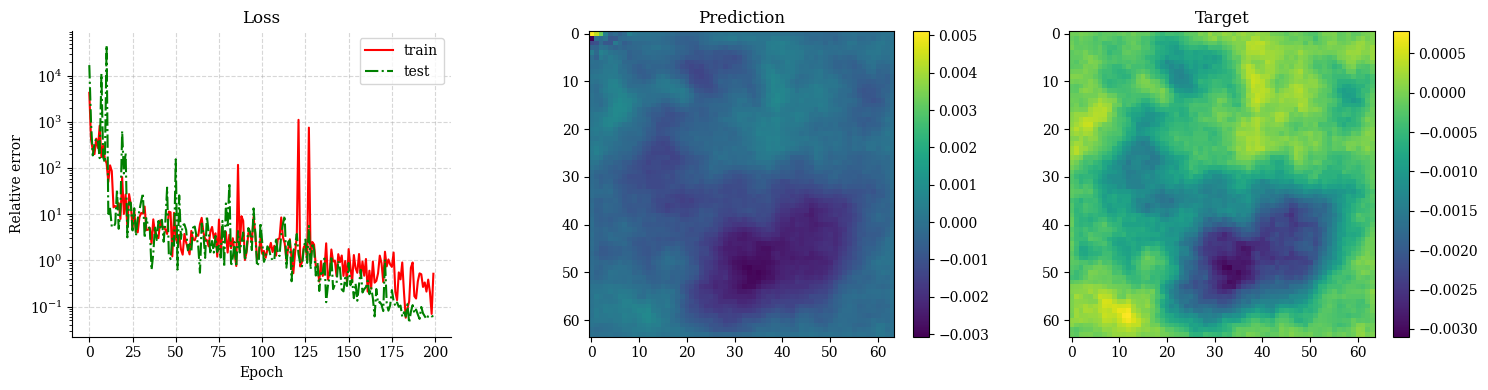

In [24]:
plot_results(model, history, feat_ts, targ_ts)

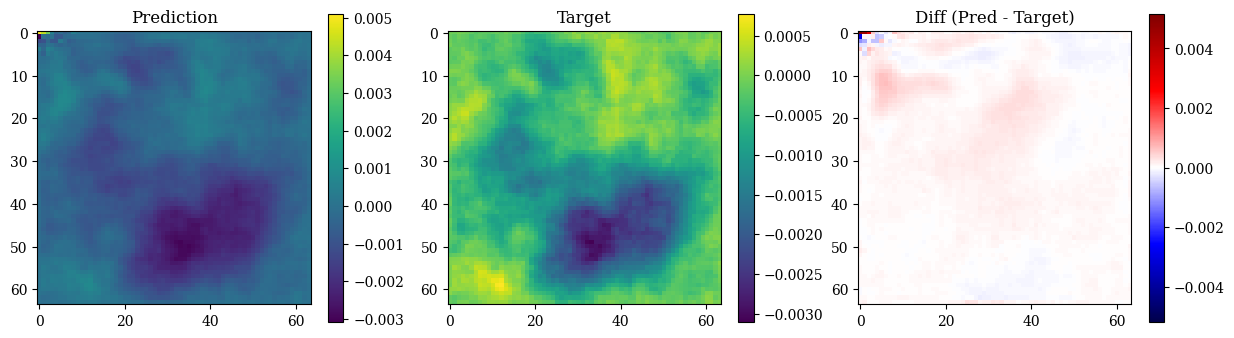

In [ ]:
import matplotlib.pyplot as plt

idx = 0 
pred_map = pred[idx, 0].cpu().numpy()
targ_map = targ_ts[idx, 0].cpu().numpy()
diff_map = pred_map - targ_map

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.title("Prediction")
plt.imshow(pred_map, cmap="viridis")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Target")
plt.imshow(targ_map, cmap="viridis")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Diff (Pred - Target)")
plt.imshow(diff_map, cmap="seismic", vmin=-abs(diff_map).max(), vmax=abs(diff_map).max())
plt.colorbar()


In [ ]:
from sklearn.linear_model import LinearRegression

y_pred = pred.view(pred.size(0), -1).cpu().numpy()
y_true = targ_ts.view(targ_ts.size(0), -1).cpu().numpy()

reg = LinearRegression().fit(y_pred, y_true)
a = reg.coef_.mean()
b = reg.intercept_.mean()

print(f"Fitted: y ≈ {a:.6f} * pred + {b:.6e}")


Fitted: y ≈ 0.000213 * pred + 1.218231e-05


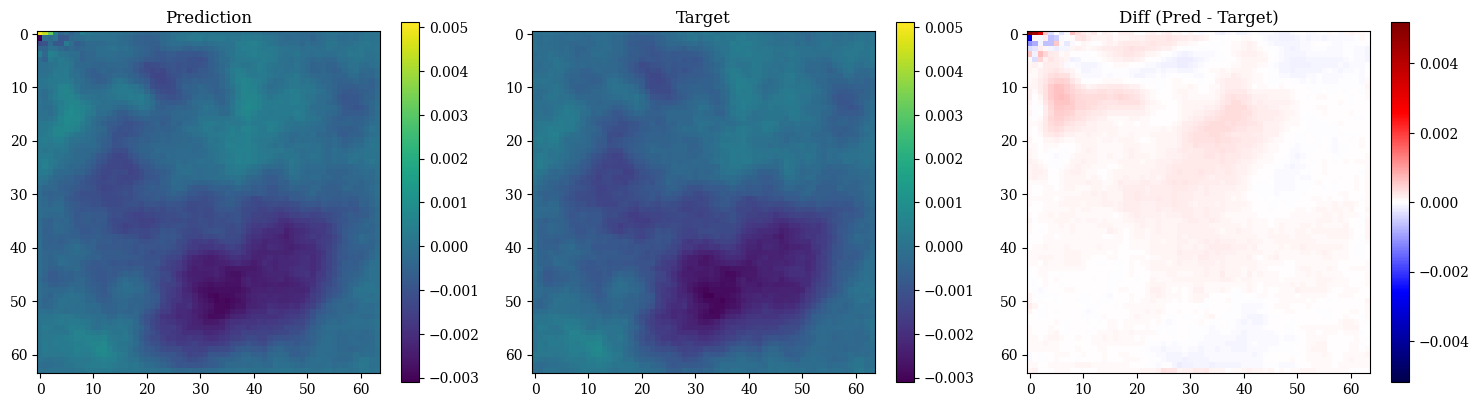

In [33]:
import matplotlib.pyplot as plt

idx = 0
pred_map = pred[idx, 0].cpu()
targ_map = targ_ts[idx, 0].cpu()
diff_map = (pred_map - targ_map)

vmin = min(pred_map.min().item(), targ_map.min().item())
vmax = max(pred_map.max().item(), targ_map.max().item())

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.title("Prediction")
plt.imshow(pred_map, cmap="viridis", vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Target")
plt.imshow(targ_map, cmap="viridis", vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Diff (Pred - Target)")
plt.imshow(diff_map, cmap="seismic", vmin=-abs(diff_map).max(), vmax=abs(diff_map).max())
plt.colorbar()

plt.tight_layout()
plt.show()


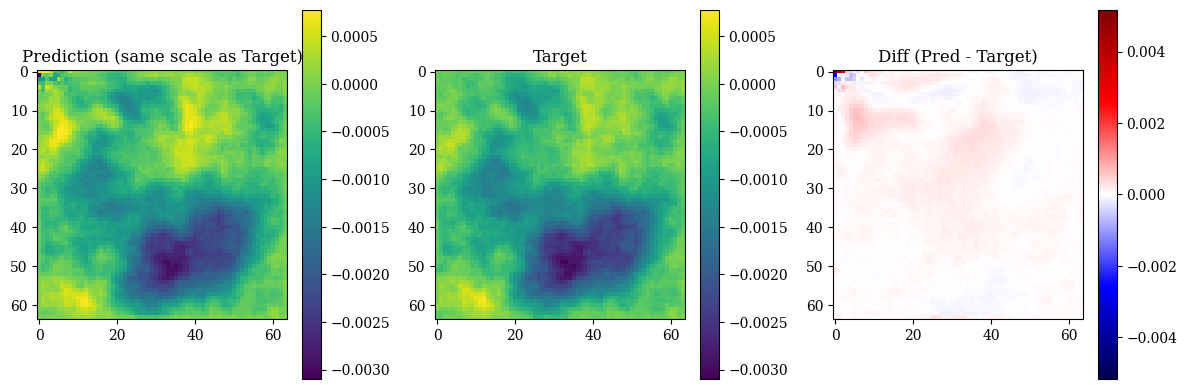

In [ ]:
import matplotlib.pyplot as plt

idx = 0
pred_map = pred[idx, 0].cpu()
targ_map = targ_ts[idx, 0].cpu()

vmin = targ_map.min().item()
vmax = targ_map.max().item()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Prediction (same scale as Target)")
plt.imshow(pred_map, cmap="viridis", vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Target")
plt.imshow(targ_map, cmap="viridis")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Diff (Pred - Target)")
diff = pred_map - targ_map
plt.imshow(diff, cmap="seismic", vmin=-abs(diff).max(), vmax=abs(diff).max())
plt.colorbar()

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

epochs = list(range(1, len(history["history_train"]) + 1))
train_vals = history["history_train"]
test_vals = history["history_test"]

selected_epochs = list(range(20, len(train_vals) + 1, 20))
table_data = {
    "Epoch": selected_epochs,
    "Train Error": [train_vals[e - 1] for e in selected_epochs],
    "Test Error": [test_vals[e - 1] for e in selected_epochs],
}

df_hist = pd.DataFrame(table_data)
df_hist


,Epoch,Train Error,Test Error
0,20,64.485458,641.543213
1,40,3.233568,2.780540
2,60,4.373380,1.532856
3,80,4.154348,17.242735
4,100,3.045391,6.571032
5,120,1.485966,2.101836
6,140,0.539415,0.444284
7,160,0.466404,0.237865
8,180,0.550335,0.098216
9,200,0.514770,0.062364
